# 

In [1]:
import numpy as np
import sys,os
sys.path.append(os.getcwd()[:-11]+'src/')
from models import *
from topological_methods import *
import matplotlib.pyplot as plt
clrs = plt.cm.tab20.colors

In [2]:
from torchvision import datasets, transforms

transform=transforms.Compose([transforms.ToTensor()])

data_train = datasets.MNIST('/Users/kosio/Data/MNIST/', train=True, transform=transform, download=True)
data_test = datasets.MNIST('/Users/kosio/Data/MNIST/', train=False, transform=transform,download=True)

trainloader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=True)


/Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <632A2621-54FC-39C2-963C-47795485AE07> /Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [11]:
#output before training
layer_sizes = [2000,1000,500,100]


model = FeedforwardNetwork(input_size=data_train.data.shape[1]*data_train.data.shape[2]
                           ,hidden_sizes=layer_sizes, out_layer_sz=10, init_type='none',
                          mean = 0, std=0.01)

test_samples = np.random.choice(np.arange(0,10000),size=10000,replace=False)
test_dat = data_test.data.reshape(len(data_test.data),-1).float()[test_samples]
out_code = np.zeros([len(test_dat),len(layer_sizes)])
for i, x_i in enumerate(test_dat):
    out_code[i,:] = model.compute_rank_at_point(x_i)[:-1]
    if i%100==0:
        print(i)
out = model(data_test.data.reshape(len(data_test.data),-1).float())


0
100
200
300
400
500
600
700
800
900
1000


KeyboardInterrupt: 

In [ ]:
rand_samples = 255*torch.randn(test_dat.shape)

out_code_pre_rand = np.zeros([len(test_dat),len(layer_sizes)])
for i, x_i in enumerate(rand_samples):
    out_code_pre_rand[i,:] = model.compute_rank_at_point(x_i)[:-1]
    if i%100==0:
        print(i)


In [ ]:
#show the PCA spectrum of the MNIST data
from sklearn.decomposition import PCA
reduced_MNIST = PCA().fit(data_test.data.reshape(len(data_test.data),-1).float())
reduced_output = PCA().fit(out[-1].detach().numpy())

plt.plot(np.arange(1,785),reduced_MNIST.explained_variance_ratio_,'k-o')
plt.plot(np.arange(1,len(reduced_output.explained_variance_ratio_)+1),reduced_output.explained_variance_ratio_,'r-o')
plt.xscale('log')

In [ ]:
#Train
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the training function
def train_model(model, trainloader, criterion, optimizer, num_epochs=20):
    model.train()  # Set the model to training mode
    for epoch in tqdm(range((num_epochs))):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs.reshape(len(inputs),-1))[-1]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if epoch % 50 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

# Train the model
train_model(model, trainloader, criterion, optimizer)


In [ ]:
#Calculate test performance
out_test = torch.argmax(model(data_test.data.float().reshape(len(data_test.data),-1))[-1],1)
print((torch.sum(out_test==data_test.targets)/len(out_test)).item())

In [ ]:
#output after training
out_code_post = np.zeros([len(test_dat),len(layer_sizes)])
for i, x_i in enumerate(test_dat):
    out_code_post[i,:] = model.compute_rank_at_point(x_i)[:-1]
    if i%100==0:
        print(i)

In [ ]:
#run model through random images to see if low ranks are placed near data samples or if in general the space is lower rank
out_code_rand = np.zeros([len(rand_samples),len(layer_sizes)])
for i, x_i in enumerate(rand_samples):
    out_code_rand[i,:] = model.compute_rank_at_point(x_i)[:-1]
    if i%100==0:
        print(i)

In [ ]:
fig, ax = plt.subplots(2,len(out_code.T),figsize=(8,2))

for i in range(len(out_code.T)):
    ax[0,i].hist(out_code[:,i],np.linspace(0,min(layer_sizes[i],784),75),
                                  color='blue',density=True)
    ax[0,i].hist(out_code_post[:,i],np.linspace(0,min(layer_sizes[i],784),75),
                                  color='orange',density=True)
    ylim = ax[0,i].get_ylim()
    ax[0,i].vlines([7,13],[0,0],[1,1],'k',lw=0.4,alpha=0.75)
    ax[0,i].set_ylim(ylim)
    ax[0,i].set_yticks([])
    

    ax[0,i].set_title("Layer " + str(i+1))

    ax[1,i].hist(out_code_pre_rand[:,i],np.linspace(0,min(layer_sizes[i],784),50),
                                  color='green',density=True)
    ax[1,i].hist(out_code_rand[:,i],np.linspace(0,min(layer_sizes[i],784),50),
                                  color='purple',density=True)
    ax[1,i].set_yticks([])
fig.tight_layout()
#fig.savefig("../MNIST_code_hist.png",dpi=500)

## Regression problem

In [10]:
from test_functions import OptFunctions
from torch.utils.data import Dataset, TensorDataset

functions = OptFunctions(10000,2)

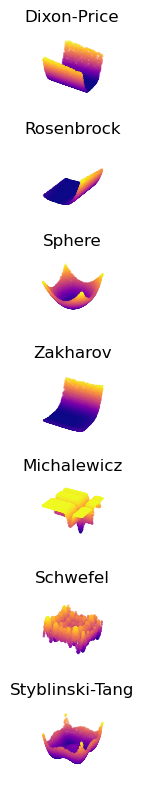

In [11]:
all_functions = [(method_name,method) for method_name, method in OptFunctions.__dict__.items() if callable(method) 
                    and not method_name.startswith("__")]
function_names = ['Dixon-Price','Rosenbrock','Sphere','Zakharov','Michalewicz','Schwefel','Styblinski-Tang']

fig, axs = plt.subplots(len(all_functions),1,figsize=(16,8),subplot_kw={'projection': '3d'})

for i in range(len(all_functions)):
    x, f_x = all_functions[i][1](functions)

    axs[i].scatter(x[0], x[1], f_x, c=f_x, cmap='plasma',s=0.5) 
    
    axs[i].axis('off')
    axs[i].set_title(function_names[i])
fig.tight_layout()
fig.savefig("../opt_functions.png",dpi=500,transparent=True)

In [31]:
discrete = False
f_dim = 30
n_samples = 10000
opt_functions = OptFunctions(n_samples,f_dim,discretize=discrete,z_score=True)
callable_methods = [method for method_name, method in OptFunctions.__dict__.items() if callable(method) 
                    and not method_name.startswith("__")]
criterion_reg = nn.MSELoss()

pretrained_codewords = []
postrained_codewords = []

for func in callable_methods:
    x_train, f_train = func(opt_functions)
    x_test, f_test = func(opt_functions)
    
    x_train, x_test = torch.tensor(x_train, dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32)
    f_train, f_test = torch.tensor(f_train, dtype=torch.float32), torch.tensor(f_test, dtype=torch.float32)

    reg_data_train = TensorDataset(x_train.T, f_train)
    reg_data_test = TensorDataset(x_test.T, f_test)
    trainloader_reg = torch.utils.data.DataLoader(reg_data_train, batch_size=64, shuffle=True)
    testloader_reg = torch.utils.data.DataLoader(reg_data_test, batch_size=64, shuffle=True)

    model_reg = FeedforwardNetwork(input_size=f_dim,hidden_sizes=[2*f_dim,f_dim,f_dim],#8*f_dim,4*f_dim,2*f_dim], 
                               out_layer_sz=1, init_type='none',activation=nn.ReLU())

    out_reg_code = np.zeros([len(x_test.T),3])
    for i, x_i in enumerate(x_test.T):
        out_reg_code[i,:] = model_reg.compute_rank_at_point(x_i)[:-1]
    #out_reg = model_reg(x_test.T)
    #out_reg_code = [torch.sum(out_reg[i]>0,axis=1) for i in range(len(out_reg))]
    pretrained_codewords.append(out_reg_code)

    if discrete:
        optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001)
    else:
        optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.0001)
        
    num_epochs = 1000
    loss_hist = []
    for epoch in range(num_epochs):
        for inputs, targets in trainloader_reg:
            # Forward pass
            outputs = model_reg(inputs)[-1]
            loss = criterion_reg(outputs, targets.unsqueeze(1))
    
            # Backward pass and optimization
            optimizer_reg.zero_grad()
            loss.backward()
            optimizer_reg.step()
            loss_hist.append(loss.item())
    
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    model_reg.eval()
    with torch.no_grad():
        out_reg_trained = model_reg(x_test.T)
    #out_reg_code_trained = [torch.sum(out_reg_trained[i]>0,axis=1) for i in range(len(out_reg_trained))]
    out_reg_code_trained = np.zeros([len(x_test.T),3])
    for i, x_i in enumerate(x_test.T):
        out_reg_code_trained[i,:] = model_reg.compute_rank_at_point(x_i)[:-1]
    postrained_codewords.append(out_reg_code_trained)


Epoch [100/1000], Loss: 0.1973
Epoch [200/1000], Loss: 0.2089
Epoch [300/1000], Loss: 0.1674
Epoch [400/1000], Loss: 0.0751
Epoch [500/1000], Loss: 0.0643
Epoch [600/1000], Loss: 0.0261
Epoch [700/1000], Loss: 0.0626
Epoch [800/1000], Loss: 0.0455
Epoch [900/1000], Loss: 0.0251
Epoch [1000/1000], Loss: 0.0493
Epoch [100/1000], Loss: 0.1547
Epoch [200/1000], Loss: 0.1217
Epoch [300/1000], Loss: 0.0719
Epoch [400/1000], Loss: 0.0801
Epoch [500/1000], Loss: 0.0998
Epoch [600/1000], Loss: 0.1052
Epoch [700/1000], Loss: 0.0706
Epoch [800/1000], Loss: 0.0810
Epoch [900/1000], Loss: 0.0705
Epoch [1000/1000], Loss: 0.0582
Epoch [100/1000], Loss: 0.1075
Epoch [200/1000], Loss: 0.0477
Epoch [300/1000], Loss: 0.0552
Epoch [400/1000], Loss: 0.0403
Epoch [500/1000], Loss: 0.0404
Epoch [600/1000], Loss: 0.0440
Epoch [700/1000], Loss: 0.0184
Epoch [800/1000], Loss: 0.0370
Epoch [900/1000], Loss: 0.0176
Epoch [1000/1000], Loss: 0.0163
Epoch [100/1000], Loss: 0.0895
Epoch [200/1000], Loss: 0.0807
Epoch

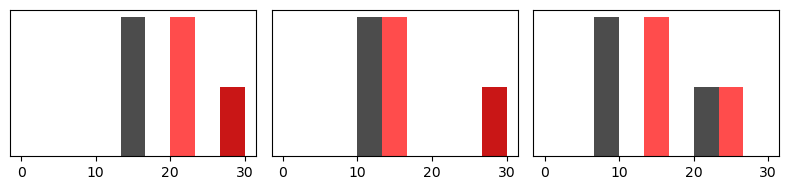

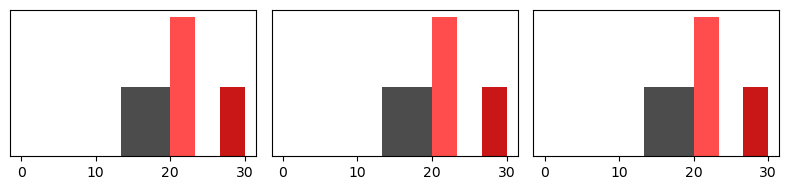

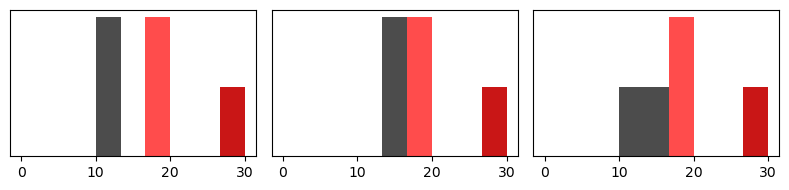

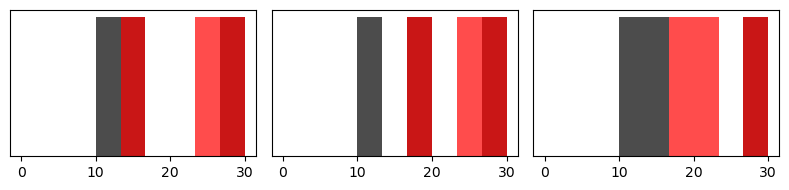

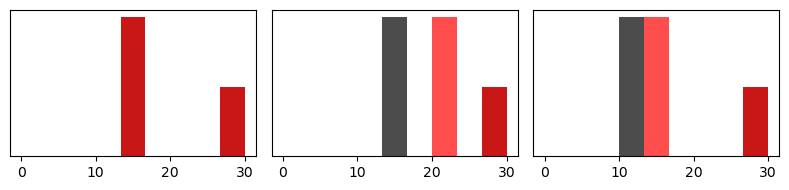

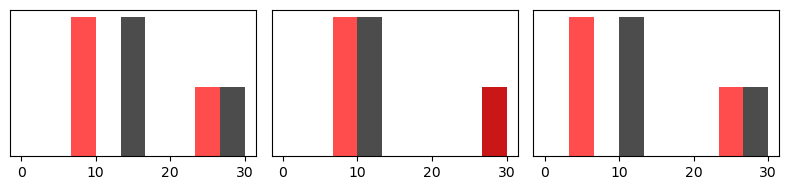

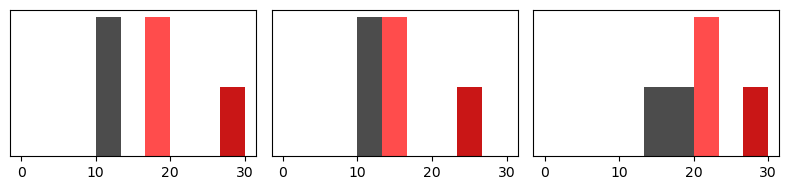

In [32]:
if discrete:
    color_hists = ['black','red']
else:
    color_hists = ['black','red']
for n,fnames in enumerate(function_names) :
    fig, ax = plt.subplots(1,len(out_reg_code.T),figsize=(8,2))

    for i in range(len(out_reg_code.T)):
        ax[i].hist(pretrained_codewords[n][i],np.linspace(0,f_dim,10),
                                      color=color_hists[0],density=True,alpha=0.7)
        ax[i].hist(postrained_codewords[n][i],np.linspace(0,f_dim,10),
                                          color=color_hists[1],density=True,alpha=0.7)
        ax[i].set_yticks([])
    fig.tight_layout()
    
    #if discrete:
    #    fig.savefig("../"+fnames+"_discrete_hist.png", dpi=500,transparent=True)
    #else:
    #    fig.savefig("../"+fnames+"_continuous_hist.png", dpi=500,transparent=True)